In [18]:
import pandas as pd
import numpy as np
#df2 = pd.read_csv("./Training_Dataframes/esken30ktweetswithemotions.csv")


In [19]:
# https://medium.com/swlh/tweet-sentiment-analysis-using-python-for-complete-beginners-4aeb4456040
# Turning all Tweets into Vectors for later Machine learning
from sklearn.feature_extraction.text import CountVectorizer
def turnTweetsIntoVector(dataframe,max_features_IN = None):
    dataframe.drop(["Unnamed: 0"],axis = 1, inplace = True)
    keyString = dataframe.keys()
    keyString += "Input"
    dataframe.columns = keyString
    listOfTweets = dataframe["editedInput"].tolist()
    docs = np.array(listOfTweets)
    cv=CountVectorizer(max_features = max_features_IN, binary = True)
    oneHotCv = cv.fit_transform(docs)
    oneHotArray = oneHotCv.toarray()
    oneHotArray.shape
    oneHotDf = pd.DataFrame(oneHotArray)
    #Naming the Columns accordingly for humans to read
    oneHotDf.columns = cv.get_feature_names_out()
    #print(oneHotDf.head())
    #print(oneHotDf.info())
    #Normalizing Emotions    
    longDf = pd.concat([dataframe,oneHotDf], axis = 1)
    #dir(CountVectorizer)
    #print(longDf.describe())
    #longDf.head()
    for emotion in longDf[longDf.keys()[12:20]]:
        longDf[emotion] = np.where(longDf[emotion]>=1, 1, 0)
    
    # ----- To check output
    
    #proving, that all words in the tweet are marked appropriatly
    #print(longDf.iloc[0]["editedInput"])
    #print(longDf.iloc[0][longDf.iloc[0]["editedInput"].split()])
    #Shows that keys[0:24] are tweet data, thats not part of the NLP
    #print(longDf.keys()[:27])
    #print(longDf.keys()[:24])
    # -----

    return longDf

In [20]:
#This is already part of old code
import re

def clean(text):
    text = re.sub(r'@[A-Za-z0-9]+\s?', '', text) #Removed Mentions
    text = re.sub(r'#', '', text) #Removed #
    text = re.sub(r'(.)1+', r'1', text) #cleaned single letters
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text) #Removes links
    text = re.sub('@','',text) #Remove @
    text = re.sub('-','',text) #Remove -
    text = re.sub('ä','ae',text) #Remove ä
    text = re.sub('Ä','Ae',text) #Remove Ä
    text = re.sub('ö','oe',text) #Remove Ä
    text = re.sub('Ö','Oe',text) #Remove Ä
    text = re.sub('ü','ue',text) #Remove Ä
    text = re.sub('Ü','Ue',text) #Remove Ä
    return text

import nltk
from nltk.stem import PorterStemmer
porter = PorterStemmer()
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

In [21]:
def sentence_toVec(sentence,goalDF):
    #Preparing Input text
    cleanSentence = sentence.lower()
    cleanSentence = clean(cleanSentence)
    cleansentene = stemming_on_text(cleanSentence)
    
    #Preparing EmptyDF
    emptyList = [0]*len(goalDF.keys())
    #print(emptyList)
    #print("Len EmptyList: " + str(len(emptyList)))
    #emptyDF = goalDF.iloc[0:0].copy()
    #emptyDF = emptyDF.append(emptyList)
    #emptyDF = emptyDF.append(pd.DataFrame(emptyList, columns = goalDF.keys()), ignore_index = True)
    emptyDF = pd.DataFrame(columns = goalDF.keys())
    #emptyDF.append(pd.Series(), ignore_index = True)
    emptyDF.loc[len(emptyDF)] = emptyList
    #print(emptyDF)
    #emptyDF = pd.DataFrame(emptyList, columns = goalDF.keys())
    #print("LenEmpty DF: " + str(len(emptyDF)) + " Len Keys Empty DF: " + str(len(emptyDF.keys())))
    
    emptyDF["textInput"][0] = sentence
    emptyDF["editedInput"][0] = cleanSentence
    #keys = list(emptyDF.keys()[0:10])
    #print("---")
    #print("New LenEmpty DF: " + str(len(emptyDF)) + " Len Keys Empty DF: " + str(len(emptyDF.keys())))
    #print(emptyDF["textInput"].tolist())
    listOfWords = cleanSentence.split()
    for word in listOfWords:
        if word in emptyDF.columns:
            emptyDF[word][0] = 1
    emptyDF.fillna(0)
    return emptyDF

In [22]:
#myPrivateSentence = "Wir sind falsch"    
#print(longDf.keys()[24])

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def generateHeatMap(y_test,y_pred, emotion):
    y_pred = y_pred.astype(np.int32)
    """
    print("len(y_test) :" + str(len((y_test))))
    print("max(y_test) :" + str(max((y_test))))
    print("----")
    print("(y_test) :\n" + str((y_test)))
    print("(y_pred) :\n" + str((y_pred)))
    print("----")
    print("type(y_pred) :" + str(type(y_pred)))
    """
    cf_matrix = confusion_matrix(y_test,y_pred)
    #print(cf_matrix)
    ax = sns.heatmap(cf_matrix, annot = True, cmap = "Blues")
    ax.set_title("Seaborn Confusion Matrix for Emotion: {}\n\n".format(str(emotion)))
    ax.set_xlabel("\nPredictedValues")
    ax.set_ylabel("Actual Values")
    
    ax.xaxis.set_ticklabels(["False","True"])
    ax.yaxis.set_ticklabels(["False","True"])
    plt.show()

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#print(list((keys)))
def trainEmotionModels(dataFrame,showHeatmap = False):
    tweet_features = dataFrame.keys()[24:]
    X_trainingData = dataFrame[tweet_features]
    #print("X_trainingData: \n" + str(X_trainingData.head()))
    keys = list(dataFrame.keys()[12:20])
    listOfModels = []
    iterator = 0
    for emotion in dataFrame[keys]:
        print(emotion[:-5] + ": ")
        #print(dataFrame[emotion].head())
        y_emotion = dataFrame[emotion]
        #print("y_emotion.head(): \n" + str(type(y_emotion)))
        train_X, val_X, train_y, val_y = train_test_split(X_trainingData, y_emotion,train_size = 0.1, test_size = 0.9, random_state = 4,shuffle=True)
        #print("Early max(val_y) " + str(max(val_y)))
        #print("type(train_X): "+ str(type(train_X)))
        #print("type(train_y): "+ str(type(train_y)))
        #print("type(val_X): "+ str(type(val_X)))
        #print("type(val_y): "+ str(type(val_y)))
        emotion_Model = DecisionTreeRegressor(random_state = 1)
        emotion_Model.fit(train_X,train_y)
        val_predictions = emotion_Model.predict(val_X)
        listOfModels.append(emotion_Model)
        #print(emotion_Model.predict(val_X.head()))
        #print(val_y.head())
        #print("len(val_y.keys()): " + str(len(val_y.keys())))
        #print("Key Examples: " + str(val_y.keys()[:-15]))
        print("Mean Absolute error for {}: ".format(emotion[:-5]) + str(round(mean_absolute_error(val_y,val_predictions)*100,2))+"%\n")
        #print("type(train_X): " + str(type(train_X)))
        #print("type(dfSentence): " + str(type(dfOfSentence)))
        #print("Predicition for for train_X.head() for emotion {}: ".format(emotion[:-5])+ str(emotion_Model.predict(train_X.head())))
        #print("Predicition for '{}' for emotion {}: ".format(myPrivateSentence,emotion[:-5])+ str(emotion_Model.predict(dfOfSentence[tweet_features])))
        #y_emotionGoal = dataFrame[emotion]
        if(showHeatmap):
            #print("type(val_y): " + str(type(val_y)) + " Content: " + str(val_y))
            #print("type(val_predictions): " + str(type(val_predictions)) + " Content: "+ str(val_predictions))
            generateHeatMap(val_y,val_predictions,emotion[:-5])
        
    dicOfModels = {"Wut-Model":listOfModels[0],"Vorfreude-Model":listOfModels[1],"Ekel-Model":listOfModels[2],"Furcht-Model":listOfModels[3],"Freude-Model":listOfModels[4],"Traurigkeit-Model":listOfModels[5], "Ueberraschungs-Model":listOfModels[6],"Vetrauen-Model":listOfModels[7]}
    return dicOfModels

In [24]:
def getAttributesOfTweet(tweetNumber, df):
    keys = list(df.keys()[12:20])
    print("---\nTweet \n--- \n" + df["textInput"][tweetNumber]+"\n--- \nhas these Emotions according to DataInput Tweet:")
    for emotion in df[keys]:
        print(str(emotion[:-5]) + "-Value: " +str(df[emotion][tweetNumber]))

In [25]:
def interpretOwnSentence(sentence, dicOfModels, df):
    if(type(sentence) != str):
        print("Sentence-Parameter is not a String")
        return
    if(type(dicOfModels) != dict):
        print("dicOfModels-Parameter is not a dictionary")
        return
    if(len(dicOfModels)!=8):
        print("dicOfModels Length is not 8")
        return
        
    #Transforming Sentence into Vector
    dfOfSentence = sentence_toVec(sentence, df)
    #print("----\nThis is the shape of the df: \n" + str(dfOfSentence) + "\n----")
    listOfIndex = dfOfSentence.columns[(dfOfSentence == 1).all()].tolist()
    listOfIndex.extend(["textInput","editedInput","WutInput"])
    #print("----\nInput Sentence was transformed to this vector: \n" +str(dfOfSentence.head()))
    keys = list(df.keys()[12:20])
    #Applying different Models to sentence
    keyOfFeatures = dfOfSentence.keys()[24:]
    features = dfOfSentence[keyOfFeatures]    
    iterator = 0
    for model in dicOfModels:
        #print(str(model) + " is the following type: " + str(type(model)))
        result = dicOfModels[model].predict(features)
        #print("---\nThis is the result of {}: ".format(str(model)) + str(result))
        #print("result[0]: " + str(result[0]))
        #print("before writing: " + str(dfOfSentence[dfOfSentence.keys()[12+iterator]]))
        #dfOfSentence[12+iterator] = result[0]
        dfOfSentence[dfOfSentence.keys()[12+iterator]][0] = result[0]
        #print(dfOfSentence[dfOfSentence.keys()[12+iterator]][0])
        #print("---\nThis is in the dfOfSentence: " + str(dfOfSentence[12+iterator][0]))
        if(dfOfSentence[dfOfSentence.keys()[12+iterator]][0]>1):
            dfOfSentence[dfOfSentence.keys()[12+iterator]][0] = 1
        iterator = iterator + 1
    #print("---\nThis is what all the Attributes look like: \n" + str(dfOfSentence[dfOfSentence.keys()[12:20]]))
    getAttributesOfTweet(0,dfOfSentence)

In [26]:
#if you want to do it by hand - else use doItAll()
"""
df_esken = pd.read_csv("./Training_Dataframes/esken30ktweetswithemotions.csv")
df_scholz = pd.read_csv("./EmotionCSV.csv")

smallSample_esken = df_esken.iloc[:5000].copy()
print(len(smallSample_esken))
print(len(df_scholz))
mixedDF = pd.concat([df_scholz,smallSample_esken])
mixedDF.reset_index(inplace = True)
print(len(mixedDF))
"""
#vectorizedDataframe_Mixed = turnTweetsIntoVector(df_scholz)
#print(vectorizedDataframe_Mixed.keys()[0:26])
#vectorizedDataframe_Mixed = vectorizedDataframe_Mixed.drop(columns = ["indexInput"])
#print(vectorizedDataframe_Mixed.keys()[0:26])
#giveMeMyModels = trainEmotionModels(vectorizedDataframe_Mixed,True)

'\ndf_esken = pd.read_csv("./Training_Dataframes/esken30ktweetswithemotions.csv")\ndf_scholz = pd.read_csv("./EmotionCSV.csv")\n\nsmallSample_esken = df_esken.iloc[:5000].copy()\nprint(len(smallSample_esken))\nprint(len(df_scholz))\nmixedDF = pd.concat([df_scholz,smallSample_esken])\nmixedDF.reset_index(inplace = True)\nprint(len(mixedDF))\n'

In [27]:
def doItAll(path):
    sampleDF = pd.read_csv(path)
    if(len(sampleDF)>5000):
        vectorizedDataframe = turnTweetsIntoVector(sampleDF, 5000)
    else:
        vectorizedDataframe = turnTweetsIntoVector(sampleDF)
    model = trainEmotionModels(vectorizedDataframe, True)
    return model, vectorizedDataframe
   

In [28]:
#myModel, vectorizedDataframe = doItAll("./EmotionCSV.csv")

In [29]:
#interpretOwnSentence("spd sieg freude glückwunsch!", myModel, vectorizedDataframe)

Wut: 
Mean Absolute error for Wut: 6.66%



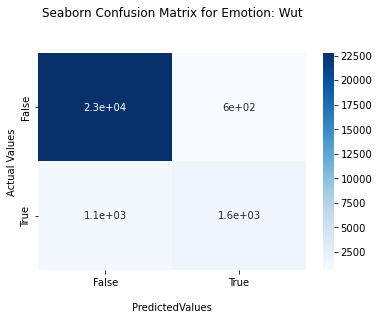

Vorfreude: 
Mean Absolute error for Vorfreude: 4.61%



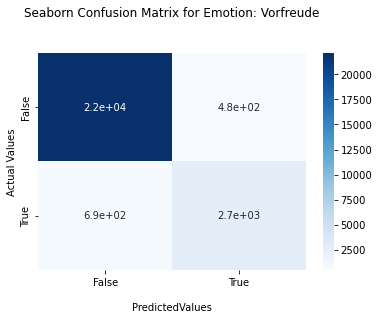

Ekel: 
Mean Absolute error for Ekel: 5.33%



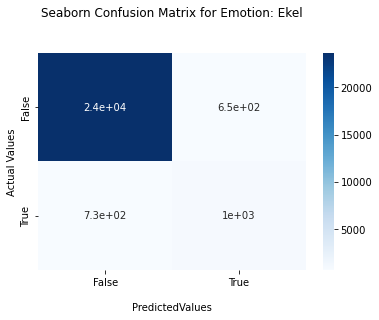

Furcht: 
Mean Absolute error for Furcht: 7.27%



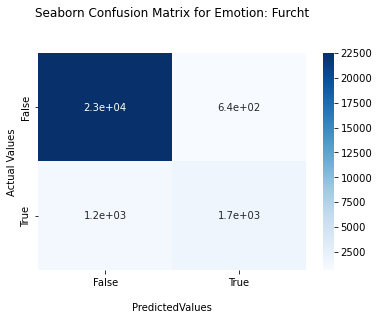

Freude: 
Mean Absolute error for Freude: 6.61%



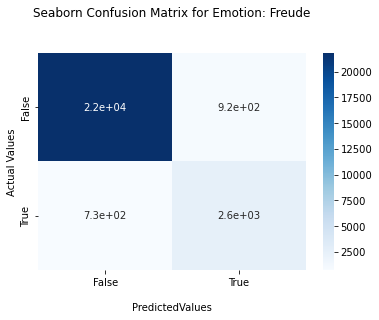

Traurigkeit: 
Mean Absolute error for Traurigkeit: 6.39%



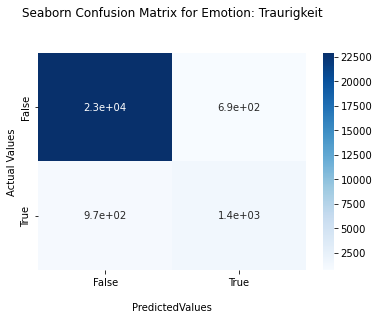

Ueberraschung: 
Mean Absolute error for Ueberraschung: 4.39%



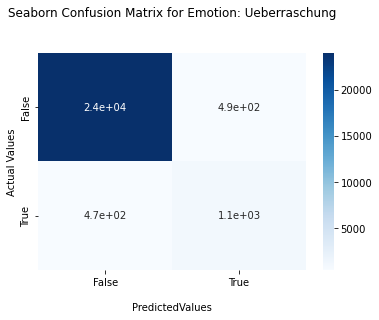

Vertrauen: 
Mean Absolute error for Vertrauen: 8.57%



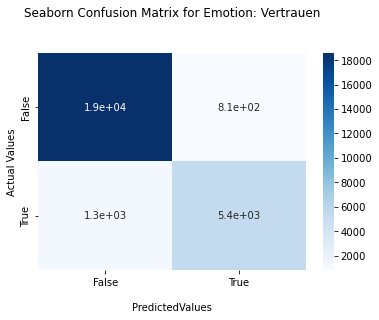

In [30]:
myModel, vectorizedDataframe  = doItAll("./Training_Dataframes/esken30ktweetswithemotions.csv")

In [36]:
#Testing Model for fun!
#print(type(df_esken["text"][0:5]))
#for tweet in df_esken["text"][0:5]:
#    interpretOwnSentence(tweet,myModel,vectorizedDataframe)
interpretOwnSentence("gruen umwelt klima streik frauen krach kriegsieg freude glückwunsch unglück freiheit gerechtigkeit!", myModel, vectorizedDataframe)

---
Tweet 
--- 
gruen umwelt klima streik frauen krach kriegsieg freude glückwunsch unglück freiheit gerechtigkeit!
--- 
has these Emotions according to DataInput Tweet:
Wut-Value: 0.0
Vorfreude-Value: 0.0
Ekel-Value: 0.0
Furcht-Value: 0.0
Freude-Value: 1.0
Traurigkeit-Value: 0.0
Ueberraschung-Value: 0.0
Vertrauen-Value: 1.0
